In [2]:
from random import randint

from datasets import load_dataset
ds = load_dataset("cnn_dailymail", "3.0.0", split="train[:30000]")
df = ds.to_pandas()

In [3]:
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from utils import preprocessing

[nltk_data] Downloading package punkt to /Users/hugo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/hugo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/hugo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hugo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/hugo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [4]:
def extract_and_clean_sentences(text):
    # 1. Découpage en phrases (avec ponctuation)
    sentences = sent_tokenize(text)

    # 2. Nettoyage phrase par phrase (retrait ponctuation, lemmatisation, etc.)
    cleaned_sentences = [preprocessing(sentence) for sentence in sentences]

    return cleaned_sentences

# Exemple d’utilisation sur une colonne 'article' d’un DataFrame pandas df
df['article_sentences'] = df['article'].apply(extract_and_clean_sentences)
df['summary_sentences'] = df['highlights'].apply(extract_and_clean_sentences)

df

,article,highlights,id,article_sentences,summary_sentences
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,[london england reuters harry potter star dani...,[harry potter star daniel radcliffe get fortun...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,[editor note behind scenes series cnn correspo...,[mentally ill inmate miami house forgotten flo...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,[minneapolis minnesota cnn driver minneapolis ...,"[new thought go die driver say, man say pickup..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,[washington cnn doctor remove five small polyp...,[five small polyp find procedure none worrisom...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,[cnn national football league indefinitely sus...,[new nfl chief atlanta falcon owner critical m...
...,...,...,...,...,...
29995,(CNN) -- Southwest Airlines is working with fe...,Employees received an internal memo about mark...,42f78711001c5a5b0364d600734fcb0b74e40beb,[cnn southwest airline work federal local offi...,"[employee receive internal memo marking plane,..."
29996,(CNN) -- A former Massachusetts state chemist ...,"Former chemist, 34, faces new charges about al...",30b0a324f3a68983f10d739e7476ac1707186c95,[cnn former massachusetts state chemist accuse...,[former chemist face new charge allege lie mas...
29997,(CNN) -- Wednesday is the 100th anniversary of...,Timothy Stanley: Wednesday is 100th anniversar...,10da0c3a628d86f7799a2c8278ec6b0a2d1235e6,[cnn wednesday anniversary richard nixon birth...,[timothy stanley wednesday anniversary richard...
29998,Washington (CNN) -- Black ice -- road ice virt...,"""Black ice was involved"" in Oregon crash that ...",29aaf113cb574f8d9283523919a1d0b390aca1ee,[washington cnn black ice road ice virtually i...,[black ice involve oregon crash kill hurt atto...


# Labelisation des données

On cherche a affecté un label a une phrase si elle est présente dans le résume de l'article.
On utilise cosine_similarity pour detecter les phrase qui ne serait pas les meme mais proches.


In [5]:
# Detecte la similirité entre deux phrase, threshold correspond au seuil de similarité renvoyé par cosine_similarity
def label_phrases_by_similarity(articles, summarys, threshold=0.5):
    all_sents = list(articles) + list(summarys)
    # On fit le vectorizer
    vectorizer = TfidfVectorizer().fit(all_sents)
    # On transforme en vecteur
    article_vecs = vectorizer.transform(articles)
    summary_vecs = vectorizer.transform(summarys)
    # On calcule la similarité entre les phrases
    sim_matrix = cosine_similarity(article_vecs, summary_vecs)
    max_sim = sim_matrix.max(axis=1)

    labels = (max_sim >= threshold).astype(int)
    return labels

In [6]:
data = []
for idx, row in df.iterrows():
    articles = row["article_sentences"]
    summarys = row["summary_sentences"]
    labels = label_phrases_by_similarity(articles, summarys, threshold=0.4)

    for sent, label in zip(articles, labels):
        data.append({"id": idx, "sentence": sent, "label": label})

clean_df = pd.DataFrame(data)

print(f"Nombre total de phrases : {len(clean_df)}")
print(f"Nombre de phrases résumées (label=1) : {clean_df['label'].sum()}")
clean_df

Nombre total de phrases : 934152
Nombre de phrases résumées (label=1) : 58357


,id,sentence,label
0,0,london england reuters harry potter star danie...,1
1,0,daniel radcliffe harry potter harry potter ord...,1
2,0,plan one people soon turn suddenly buy massive...,0
3,0,think particularly extravagant,0
4,0,thing like buy thing cost pound book cd dvd,0
...,...,...,...
934147,29999,last week four peacekeeper african nation miss...,0
934148,29999,unamid force commander patrick nyamvumba conde...,0
934149,29999,sudan military plane crash kill,0
934150,29999,supermodel south sudan homecoming,0


# Choix et entrainement du model

In [10]:
from gensim.models import FastText

texts = clean_df["sentence"].to_list()
labels = clean_df["label"].to_list()

# Tokenisation du texte avant de fit le modele d'embending :
tokenized_texts = [text.split() for text in texts]

# Tes textes sont déjà tokenisés et lemmatisés : `tokenized_texts`
fasttext_model = FastText(
    sentences=tokenized_texts,
    vector_size=100,      # dimension des vecteurs
    window=5,             # taille du contexte
    min_count=2,          # ignorer les mots trop rares
    workers=4,            # threads
    sg=1,                 # 1 = skip-gram, 0 = CBOW
    epochs=10             # nombre d'époques
)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creation du dictionnaire de Fasttext
word_index = {word: idx + 1 for idx, word in enumerate(fasttext_model.wv.index_to_key)}
vocab_size = len(word_index) + 1  # +1 pour le padding

# Texte vers séquences d’index
def encode_text(tokens):
    return [word_index[word] for word in tokens if word in word_index]

encoded_texts = [encode_text(tokens) for tokens in tokenized_texts]

# Padding pour avoir toute les sequences d'une meme longueure
MAX_LEN = 100
padded_texts = pad_sequences(encoded_texts, maxlen=MAX_LEN, padding='post')

In [13]:
from sklearn.model_selection import GroupShuffleSplit
# Ajout dans clean_df pour le split
clean_df["encoded"] = list(padded_texts)

# Split par article_id
X = np.array(list(clean_df["encoded"]))
y = clean_df["label"].values
groups = clean_df["id"].values

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

In [14]:
from tensorflow.keras.layers import Embedding
# Matrice embedding
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = fasttext_model.wv[word]

# Creation de la couche d'embending
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

model = Sequential([
    embedding_layer,
    # Convolution pour capter les n-grammes importants
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Bidirectional LSTM pour le contexte global
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    # Classification finale
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(
    loss='binary_crossentropy',  # ou 'categorical_crossentropy' si one-hot
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     7,702,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,865,973 (30.01 MB)

 Trainable params: 163,073 (637.00 KB)

 Non-trainable params: 7,702,900 (29.38 MB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping pour stopper l'entrainement si plus de progrès après 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # arrêt si pas d'amélioration pendant 3 epochs
    restore_best_weights=True
)

params = {
    "epochs": 5,
    "batch_size": 64,
    "learning_rate": 0.001,
}

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=params["batch_size"],
    epochs=params["epochs"],
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 695s 59ms/step - accuracy: 0.9380 - loss: 0.2210 - val_accuracy: 0.9366 - val_loss: 0.2184
Epoch 2/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 784s 67ms/step - accuracy: 0.9379 - loss: 0.2153 - val_accuracy: 0.9371 - val_loss: 0.2175
Epoch 3/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 820s 70ms/step - accuracy: 0.9383 - loss: 0.2107 - val_accuracy: 0.9370 - val_loss: 0.2201
Epoch 4/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 832s 71ms/step - accuracy: 0.9381 - loss: 0.2056 - val_accuracy: 0.9372 - val_loss: 0.2202
Epoch 5/5
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 865s 74ms/step - accuracy: 0.9382 - loss: 0.1999 - val_accuracy: 0.9371 - val_loss: 0.2239


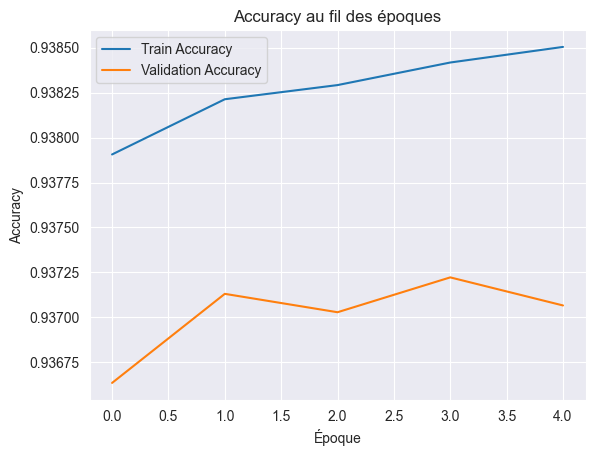

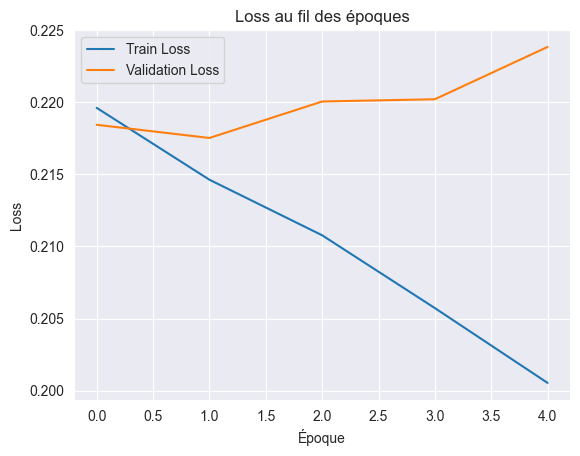

In [20]:
import matplotlib.pyplot as plt

# Courbe de précision (accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy au fil des époques')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbe de perte (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss au fil des époques')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
new = load_dataset("cnn_dailymail", "3.0.0", split="test[:5000]")
test = new.to_pandas()

In [29]:
test

,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,c27cf1b136cc270023de959e7ab24638021bc43f
...,...,...,...
4995,Unblinking eyes stare from decapitated heads a...,Heads and loose limbs are piled up on the shel...,1f4e660e020ab98a4fddd0ce4125db3b913ec1e5
4996,An app which allows users to superimpose image...,Scar Booth allows users to superimpose cuts an...,e79e40746dbc24643a3a3f044d2f49689ff82e38
4997,A Spanish hospital claims it has performed the...,Vall d'Hebron hospital in Barcelona claims it ...,dc35c4f9d1e50d06f2db660c2b4cccd881f061a4
4998,Scientists have revealed a sophisticated new d...,Little Foot was unearthed in the 1990s in Sout...,f577ace0b8ae351e6b80f73ba7fea4c06c3bb21d


In [30]:
# Exemple d’utilisation sur une colonne 'article' d’un DataFrame pandas df
test['article_sentences'] = test['article'].apply(extract_and_clean_sentences)
test['summary_sentences'] = test['highlights'].apply(extract_and_clean_sentences)

data = []
for idx, row in test.iterrows():
    articles = row["article_sentences"]
    summarys = row["summary_sentences"]
    labels = label_phrases_by_similarity(articles, summarys, threshold=0.4)

    for sent, label in zip(articles, labels):
        data.append({"id": idx, "sentence": sent, "label": label})

test_clean = pd.DataFrame(data)

In [31]:
test_clean

,id,sentence,label
0,0,cnn palestinian authority officially become me...,0
1,0,formal accession mark ceremony hague netherlan...,0
2,0,palestinian sign icc found rome statute januar...,1
3,0,later month icc open preliminary examination s...,0
4,0,member court palestinian may subject well,0
...,...,...,...
148351,4999,directv say disagrees nad finding respect rank...,0
148352,4999,operator discontinue ad claim always schedule ...,1
148353,4999,want launch new campaign hannah davis final fo...,0
148354,4999,always reserve right bring back rob lowe campa...,0


In [33]:
# Traitement du texte avant l'utilisation du model
test_texts = test_clean["sentence"].to_list()
test_labels = test_clean["label"].to_list()
tokenized_texts_test = [text.split() for text in test_texts]
encoded_texts_test = [encode_text(tokens) for tokens in tokenized_texts_test]
padded_texts_test = pad_sequences(encoded_texts_test, maxlen=MAX_LEN, padding='post')

X_test = np.array(padded_texts_test)
y_test = np.array(test_labels)

In [34]:
# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print(f"Loss sur le test set : {test_loss:.4f}")
print(f"Accuracy sur le test set : {test_accuracy:.4f}")

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.9389 - loss: 0.2173
Loss sur le test set : 0.2570
Accuracy sur le test set : 0.9241


In [35]:
# Prédictions probabilistes (sigmoid output)
y_pred_prob = model.predict(X_test, batch_size=64).flatten()  # sortie (N,1) → (N,)

# Prédictions de classes (seuil à 0.5)
y_pred_classes = (y_pred_prob >= 0.5).astype(int)

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step


              precision    recall  f1-score   support

           0       0.92      1.00      0.96    137103
           1       0.14      0.00      0.00     11253

    accuracy                           0.92    148356
   macro avg       0.53      0.50      0.48    148356
weighted avg       0.86      0.92      0.89    148356



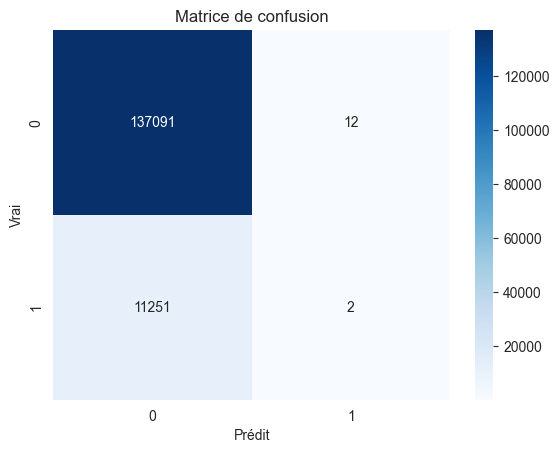

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de confusion')
plt.show()

In [40]:
from nltk.tokenize import sent_tokenize
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Exemple d'article
article = """“Global Climate Summit Sparks Hope and Debate”

The recent Global Climate Summit brought together leaders from over 190 countries to discuss urgent actions to combat climate change. The summit focused on reducing carbon emissions, investing in renewable energy, and supporting vulnerable nations impacted by rising sea levels. While many countries pledged to strengthen their climate commitments, some delegates expressed concerns over the feasibility of these targets and the economic impact of rapid transitions.

Environmental activists praised the summit’s emphasis on sustainable development but urged for faster implementation and greater accountability. Discussions also highlighted the role of technology and innovation in addressing climate challenges, including advancements in carbon capture and storage. The summit concluded with a call for continued collaboration and increased funding to meet global climate goals."""

# 1. Tokenize en phrases
sentences = sent_tokenize(article)

# 2. Nettoyage et encodage
cleaned_sentences = [preprocessing(sentence) for sentence in sentences]
tokenized_sentences = [sent.split() for sent in cleaned_sentences]
encoded_sentences = [encode_text(tokens) for tokens in tokenized_sentences]

# 3. Padding
padded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, padding='post')
X_val = np.array(padded_sentences)

import numpy as np

# 4. Prédiction
predicted_probs = model.predict(X_val).flatten()  # shape (n_samples, 1) -> (n_samples,)

# Trouver les indices des top 3 phrases les plus probables
top_k = 3
top_k_idx = np.argsort(predicted_probs)[-top_k:][::-1]  # indices triés décroissants

# 6. Affichage résumé des top 3 phrases
print("\nRésumé extrait (top 3 phrases) :")
for idx in top_k_idx:
    print(f"- {sentences[idx]} (proba: {predicted_probs[idx]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Résumé extrait (top 3 phrases) :
- “Global Climate Summit Sparks Hope and Debate”

The recent Global Climate Summit brought together leaders from over 190 countries to discuss urgent actions to combat climate change. (proba: 0.0714)
- The summit concluded with a call for continued collaboration and increased funding to meet global climate goals. (proba: 0.0678)
- The summit focused on reducing carbon emissions, investing in renewable energy, and supporting vulnerable nations impacted by rising sea levels. (proba: 0.0648)


In [42]:
article = """““Breakthrough in Quantum Computing Promises Unprecedented Processing Power”

A team of researchers from MIT and Google has announced a major milestone in quantum computing, unveiling a new quantum processor capable of solving complex problems at speeds far beyond traditional supercomputers.
The processor, named “QuantaX,” leverages a novel qubit stabilization technique that significantly reduces error rates, which has been one of the most persistent challenges in quantum systems.
According to the team, this advancement could eventually revolutionize fields like cryptography, pharmaceutical development, and climate modeling by enabling previously infeasible simulations.
However, experts caution that while the breakthrough is remarkable, commercial applications are still years away due to engineering limitations and high operational costs.
The announcement has reignited global interest and competition in quantum technologies, with major tech firms and governments accelerating their investments in research.
Analysts note that the race for quantum supremacy is as much geopolitical as it is technological, with nations seeking to secure strategic advantages through computing power."""

# 1. Tokenize en phrases
sentences = sent_tokenize(article)

# 2. Nettoyage et encodage
cleaned_sentences = [preprocessing(sentence) for sentence in sentences]
tokenized_sentences = [sent.split() for sent in cleaned_sentences]
encoded_sentences = [encode_text(tokens) for tokens in tokenized_sentences]

# 3. Padding
padded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, padding='post')
X_val = np.array(padded_sentences)

import numpy as np

# 4. Prédiction
predicted_probs = model.predict(X_val).flatten()  # shape (n_samples, 1) -> (n_samples,)

# Trouver les indices des top 3 phrases les plus probables
top_k = 3
top_k_idx = np.argsort(predicted_probs)[-top_k:][::-1]  # indices triés décroissants

# 6. Affichage résumé des top 3 phrases
print("\nRésumé extrait (top 3 phrases) :")
for idx in top_k_idx:
    print(f"- {sentences[idx]} (proba: {predicted_probs[idx]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Résumé extrait (top 3 phrases) :
- The announcement has reignited global interest and competition in quantum technologies, with major tech firms and governments accelerating their investments in research. (proba: 0.0837)
- ““Breakthrough in Quantum Computing Promises Unprecedented Processing Power”

A team of researchers from MIT and Google has announced a major milestone in quantum computing, unveiling a new quantum processor capable of solving complex problems at speeds far beyond traditional supercomputers. (proba: 0.0799)
- The processor, named “QuantaX,” leverages a novel qubit stabilization technique that significantly reduces error rates, which has been one of the most persistent challenges in quantum systems. (proba: 0.0485)


In [43]:
#Sauvegarde du model
model.save(f"ML_Sumarizer/model_DL.keras")

In [44]:
import joblib
joblib.dump(word_index, "ML_Sumarizer/word_index_sum.pkl")

['ML_Sumarizer/word_index_sum.pkl']